### Transformers Beyond Just Natural Language

**Semantic Similarity :**

In this directory, there is a JSON file containing the abstracts of the scientific papers in the DIT publication database. Each abstract has a set of co-authors. With the use of transformers, construct the latent space of this database. After finding the Euclidean distances between the paper embeddings, find the distances between every possible pair of authors. Finally, for every author, recommend 5 authors that are the closest (and not co-authors). This should pair the authors by semantic similarity of research papers. These close authors should have a cup of coffee and discuss a potential collaboration.Feel free to map the embeddings of the papers using a mapping method of your choosing and display it on a 2D plane. Further clustering using k-means is also an option to get the different clusters in the latent space. If you clustered your embeddings (maybe 5 to 8 clusters), apply KeyBERT to extract the keywords of each cluster and display them in Wordclouds to observe the semantic topics of each cluster.

#### Solution to the exercise 

#### Import the required Libararies 

In [19]:
import json
import re
import numpy as np
import pandas as pd
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from keybert import KeyBERT
from wordcloud import WordCloud
import plotly.express as px

**Load the Data:** 
- The JSON file containing papers is loaded into a variable called papers.

**Text Preprocessing:**
- The preprocess_text function converts text to lowercase, removes non-word characters, and extra whitespace.
- Abstracts are preprocessed using this function, and author names are formatted into a list of full names.

In [20]:
# Load the Data
with open('papers.json', 'r', encoding="utf-8") as file:
    papers = json.load(file)

# Text Preprocessing
def preprocess_text(text):
    if text is None:
        return ""
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
    
# Preprocess abstracts and format authors' names
for paper in papers:
    paper['abstract'] = preprocess_text(paper.get('abstractText'))
    paper['authors'] = [f"{author['person']['firstname']} {author['person']['lastname']}" for author in paper.get('referenceAuthors', [])]

**Generate Embeddings:**

- A SentenceTransformer model (all-MiniLM-L6-v2) generates embeddings for the abstracts.
- These embeddings are added to each paper's data.

**Compute Euclidean Distances:**
- Euclidean distances between the embeddings of the papers are calculated to measure similarity.

**Author Embeddings:**
- Embeddings are aggregated for each author by averaging the embeddings of papers they have authored.

**Author Similarity:**
- Pairwise distances between author embeddings are computed to measure similarity between authors.

**Find Closest Authors:**
- For each author, the closest non-co-authoring authors are identified based on the computed distances.

In [21]:
# Generate Embeddings using SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  # Initialize the transformer model

abstracts = [paper['abstract'] for paper in papers]  # Extract all abstracts
embeddings = model.encode(abstracts, batch_size=32, show_progress_bar=True)  # Generate embeddings

# Add embeddings to each paper
for i, paper in enumerate(papers):
    paper['embedding'] = embeddings[i]

# Compute Euclidean Distances
distances = euclidean_distances(embeddings)  # Compute pairwise distances between embeddings

# Author Embeddings
author_embeddings = defaultdict(list)

# Collect embeddings for each author
for paper in papers:
    for author in paper['authors']:
        author_embeddings[author].append(paper['embedding'])

# Compute average embedding for each author
for author in author_embeddings:
    author_embeddings[author] = np.mean(author_embeddings[author], axis=0)

# Author Similarity
author_names = list(author_embeddings.keys())
author_vectors = np.vstack(list(author_embeddings.values()))

author_distances = euclidean_distances(author_vectors)  # Compute distances between author embeddings

# Find Closest Authors
author_recommendations = defaultdict(list)

# Find the closest authors who are not co-authors
for i, author in enumerate(author_names):
    distances = [(author_names[j], author_distances[i][j]) for j in range(len(author_names)) if author_names[j] != author]
    distances.sort(key=lambda x: x[1])
    co_authors = {coauthor for paper in papers for coauthor in paper['authors'] if author in paper['authors']}
    closest_authors = [name for name, dist in distances if name not in co_authors][:5]
    author_recommendations[author] = closest_authors


Batches:   0%|          | 0/236 [00:00<?, ?it/s]

**For example we find the recommended authors have coffee with 'P. Lebreton'**

In [22]:
author_recommendations['P. Lebreton']

['M. Urvoy', 'J. Li', 'V. Ricordel', 'W. Chen', 'J. Fournier']

**Dimensionality Reduction and Visualization:**

- TSNE reduces the dimensionality of the author embeddings to 2D for visualization.
- A scatter plot displays the authors in a 2D space, annotated with their names.

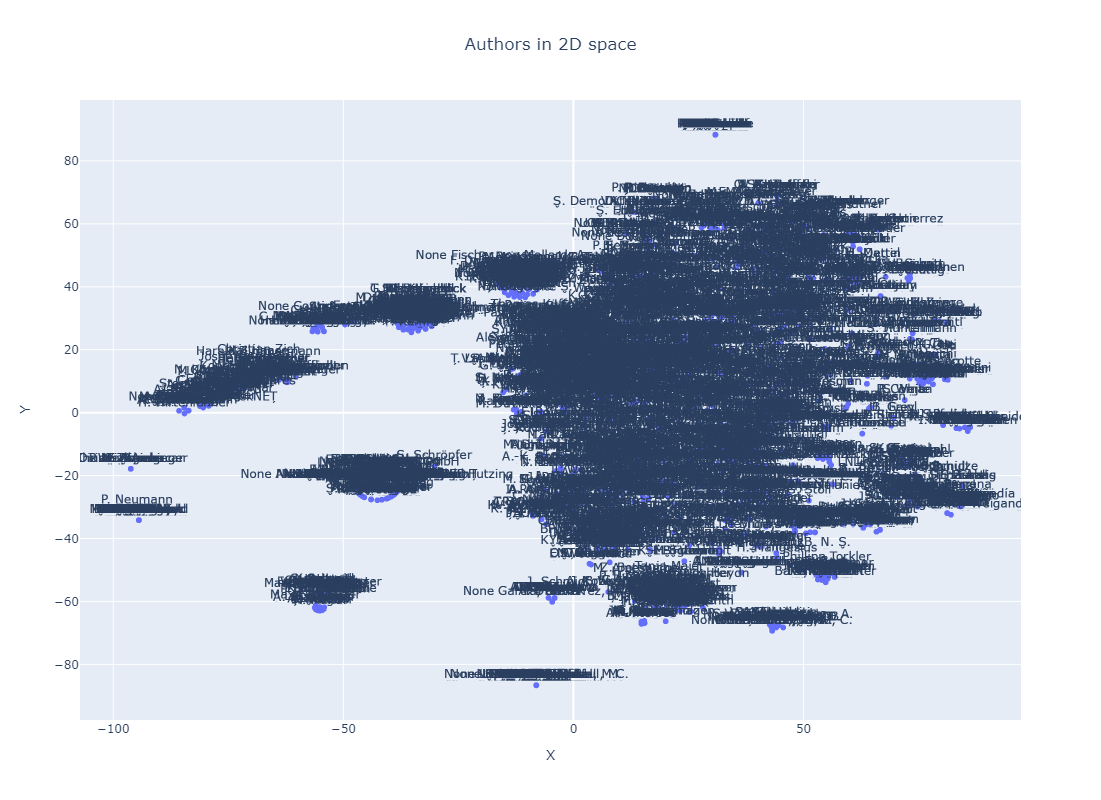

In [23]:
# Dimensionality Reduction and Visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(author_vectors)  # Reduce dimensions to 2D for visualization

# Create a DataFrame for Plotly
df = pd.DataFrame({
    'x': reduced_embeddings[:, 0],
    'y': reduced_embeddings[:, 1],
    'author': author_names
})

# Create an interactive scatter plot using Plotly
fig = px.scatter(df, x='x', y='y', text='author',
                 title='Authors in 2D space',
                 labels={'x': 'X', 'y': 'Y'},
                 height=800, width=1100)

# Update layout for better appearance
fig.update_traces(textposition='top center')
fig.update_layout(
    xaxis_title='X',
    yaxis_title='Y',
    title={'x': 0.5, 'xanchor': 'center'},
    hovermode='closest'
)

# Show the plot
fig.show()


**Clustering:**
- KMeans clusters the authors into 8 groups based on their embeddings.
- A scatter plot visualizes these clusters in the reduced 2D space.

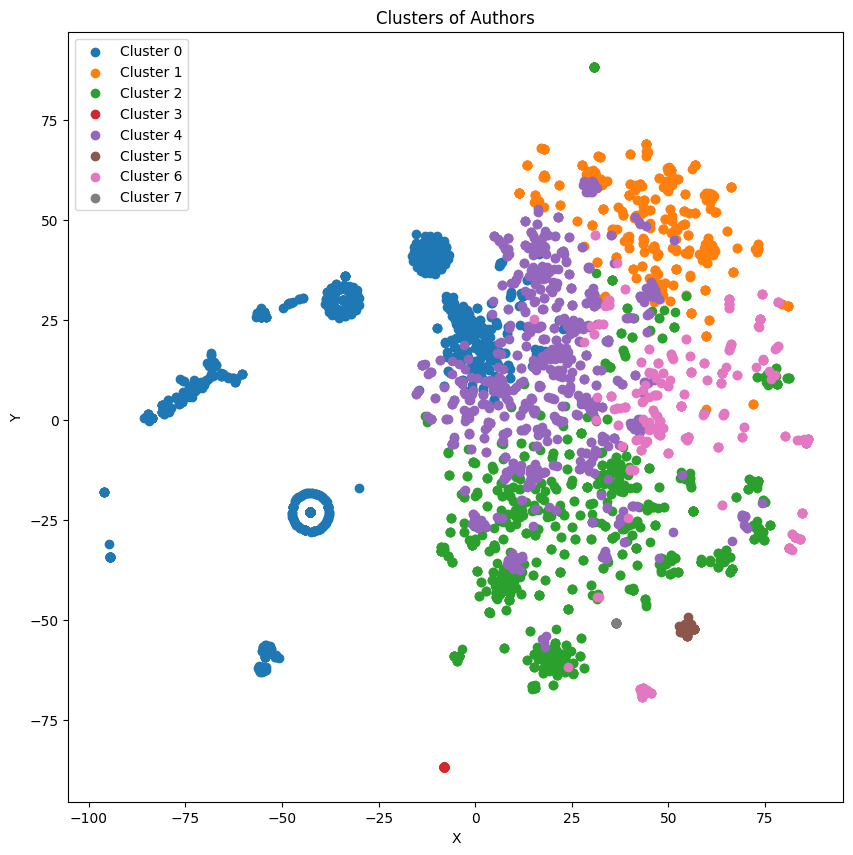

In [24]:
#  Clustering
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(author_vectors)
# Plot clusters
plt.figure(figsize=(10, 10))
for i in range(8):
    cluster_points = reduced_embeddings[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
plt.legend()
plt.title('Clusters of Authors')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

**Keyword Extraction:**
- KeyBERT extracts keywords from the abstracts in each cluster.
- Word clouds visualize the most significant keywords for each cluster, providing insights into the main topics of each group.

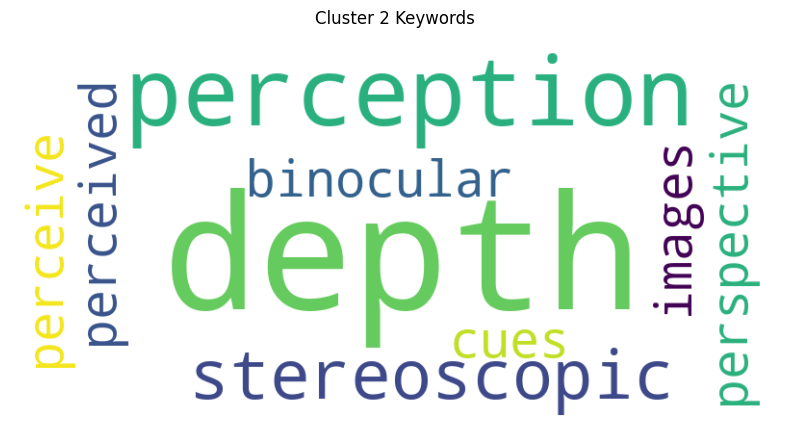

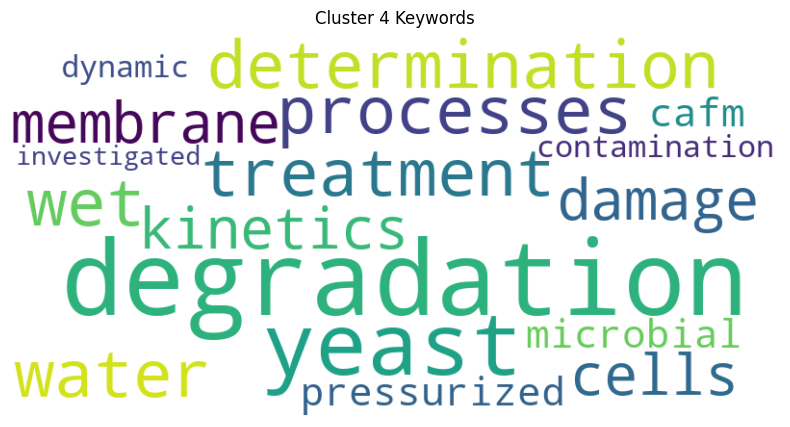

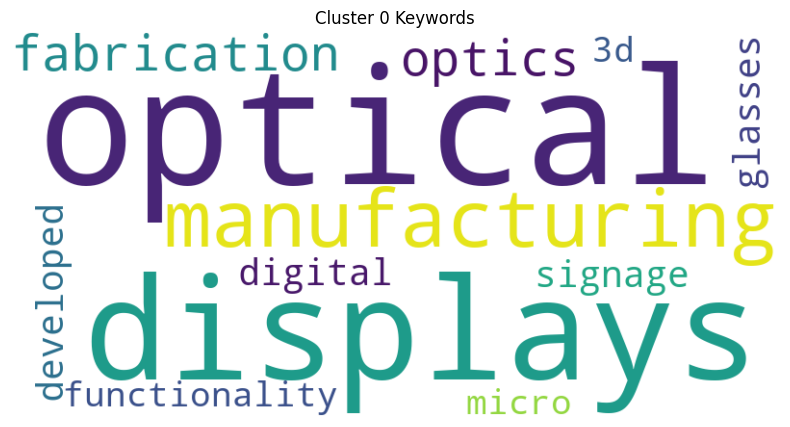

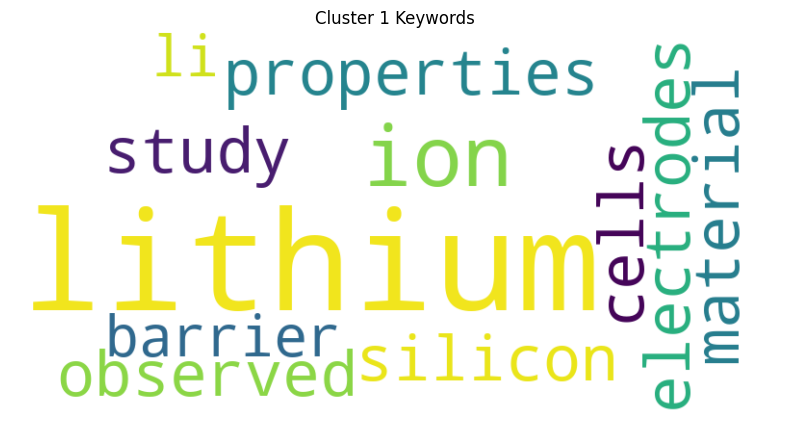

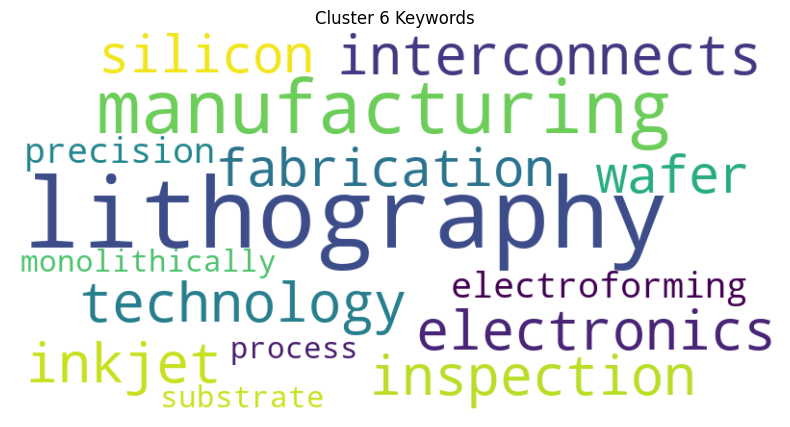

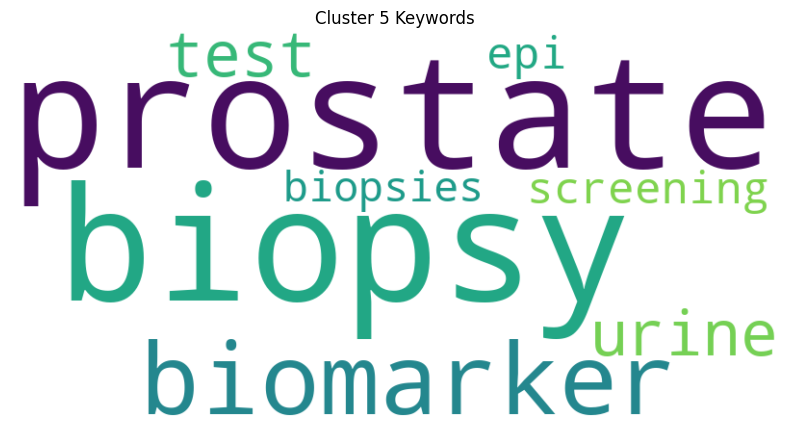

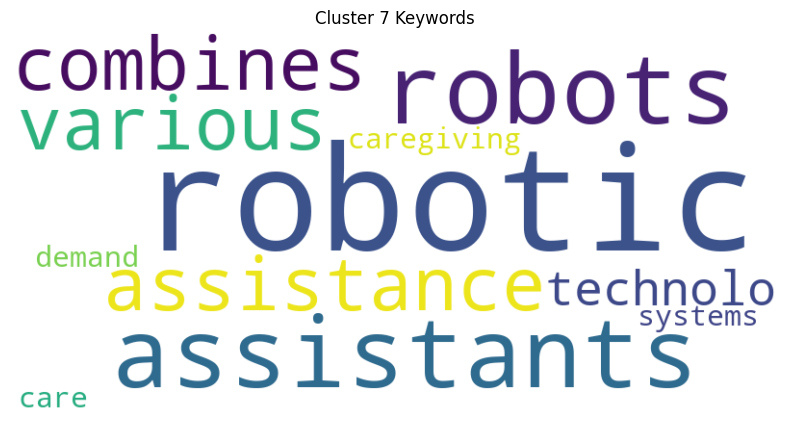

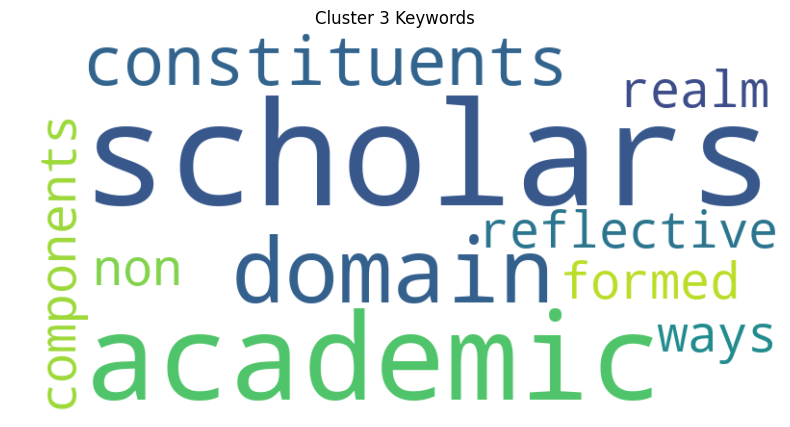

In [25]:
# Keyword Extraction
kw_model = KeyBERT(model)

cluster_texts = defaultdict(str)
# Combine abstracts for each cluster
for i, author in enumerate(author_names):
    cluster_texts[clusters[i]] += ' ' + ' '.join([paper['abstract'] for paper in papers if author in paper['authors']])
# Extract and visualize keywords for each cluster
for cluster in cluster_texts:
    keywords = kw_model.extract_keywords(cluster_texts[cluster], keyphrase_ngram_range=(1, 2), stop_words='english', top_n=10)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join([kw for kw, _ in keywords]))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster} Keywords')
    plt.show()